In [1]:
# Illustrate the impact of using batch normalization even on just a 3 hidden layer neural network

import os
import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt


In [2]:
class basicMLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100,10)
        )
        
    def forward(self, x):
        return self.layers(x)

class postactivationMLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 100),
            nn.BatchNorm1d(100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.Tanh(),
            nn.Linear(100,10)
        )
        
    def forward(self, x):
        return self.layers(x)
    
class preactivationMLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 100),
            nn.Tanh(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.BatchNorm1d(100),
            nn.Linear(100,10)
        )
        
    def forward(self, x):
        return self.layers(x)

In [3]:
# Set fixed random number seed for reproducibility
torch.manual_seed(52)

device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(), # converts pixel values to in [0,1]
    transforms.Normalize((0.5,), (0.5,)) 
    # given arguments (mean[1],...,mean[n]), (std[1],...,std[n]), normalizes the
    # input channels separately with output[i] = (input[i] - mean[i])/std[i] 
    # so this maps the pixels to the range [-1,1]
])

train_dataset = FashionMNIST(os.getcwd(), download=True, train=True, transform=transform) 
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=1)

val_dataset = FashionMNIST(os.getcwd(), download=True, train=False, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=1)

In [4]:
def train_epoch(model, criterion, optimizer, trainloader, verbose=True):
    model.train()
    numbatches = len(trainloader)
    if verbose: 
        print("Starting epoch")
        print("--------------")
    for (idx, (inputs, targets)) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (idx + 1) % 100 == 0:
            if verbose: print(f"\t Training loss on minibatch {idx+1}/{numbatches}: {loss.item():>5f}")
    if verbose:
        print("Finished epoch")
        print("--------------")

def validate(model, criterion, valloader):
    model.eval()
    test_loss = 0
    correct = 0
    numsamples = len(valloader.dataset)
    with torch.no_grad():
        for (idx, (inputs, targets)) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            correct += (outputs.argmax(1) == targets).type(torch.float).sum().item()
    loss = test_loss/numsamples
    accuracy = 100*correct/numsamples
    print(f"Validation loss/accuracy: {loss:>5f}/{accuracy:>5f}")
    return loss, accuracy

In [5]:
criterion = nn.CrossEntropyLoss()
lr = 1e-2
epochs = 20

noBN = basicMLP()
betweenBN = postactivationMLP()
afterBN = preactivationMLP()

noBN.to(device)
betweenBN.to(device)
afterBN.to(device)

optimizer_noBN = torch.optim.Adam(noBN.parameters(), lr=lr)
optimizer_betweenBN = torch.optim.Adam(betweenBN.parameters(), lr=lr)
optimizer_afterBN = torch.optim.Adam(afterBN.parameters(), lr=lr)

losses_noBN = []
losses_betweenBN = []
losses_afterBN = []

accuracies_noBN = []
accuracies_betweenBN = []
accuracies_afterBN = []

print("Training naive MLP")
print("------------------")
for e in range(epochs):
    train_epoch(noBN, criterion, optimizer_noBN, train_loader, verbose=False)
    loss, accuracy = validate(noBN, criterion, val_loader)
    losses_noBN.append(loss)
    accuracies_noBN.append(accuracy)

print("------------------")

print("Training MLP with post-activation normalization")
print("------------------")
for e in range(epochs):
    train_epoch(betweenBN, criterion, optimizer_betweenBN, train_loader, verbose=False)
    loss, accuracy = validate(betweenBN, criterion, val_loader)
    losses_betweenBN.append(loss)
    accuracies_betweenBN.append(accuracy)
print("------------------")

print("Training MLP with pre-activation normalization")
print("------------------")
for e in range(epochs):
    train_epoch(afterBN, criterion, optimizer_afterBN, train_loader, verbose=False)
    loss, accuracy = validate(afterBN, criterion, val_loader)
    losses_afterBN.append(loss)
    accuracies_afterBN.append(accuracy)
print("------------------")

Training naive MLP
------------------
Validation loss/accuracy: 0.004915/77.830000
Validation loss/accuracy: 0.004793/78.520000
Validation loss/accuracy: 0.004470/80.180000
Validation loss/accuracy: 0.005194/76.030000
Validation loss/accuracy: 0.005116/77.200000
Validation loss/accuracy: 0.004794/79.420000
Validation loss/accuracy: 0.005006/78.220000
Validation loss/accuracy: 0.005130/77.390000
Validation loss/accuracy: 0.005018/77.530000
Validation loss/accuracy: 0.004828/78.990000
Validation loss/accuracy: 0.004771/79.540000
Validation loss/accuracy: 0.004553/79.290000
Validation loss/accuracy: 0.005161/76.140000
Validation loss/accuracy: 0.005156/76.570000
Validation loss/accuracy: 0.005196/77.540000
Validation loss/accuracy: 0.005223/77.190000
Validation loss/accuracy: 0.005644/75.620000
Validation loss/accuracy: 0.005155/76.950000
Validation loss/accuracy: 0.005224/77.270000
Validation loss/accuracy: 0.004945/78.970000
------------------
Training MLP with post-activation normaliza

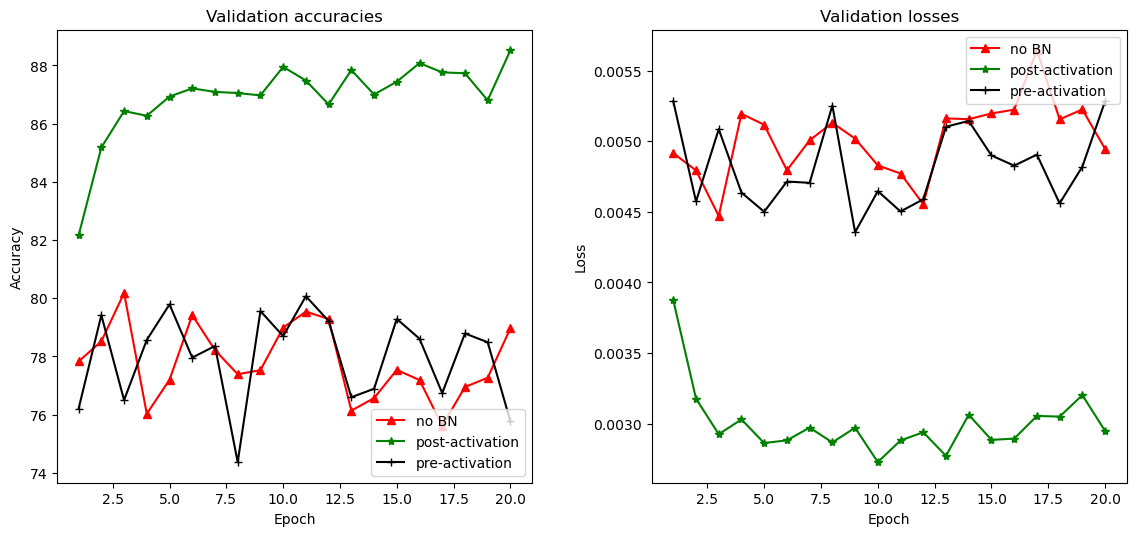

In [6]:
indicies = torch.arange(epochs)+1

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(indicies, accuracies_noBN, "r^", ls="-", label="no BN")
ax1.plot(indicies, accuracies_betweenBN, "g*", ls="-", label="post-activation")
ax1.plot(indicies, accuracies_afterBN, "k+", ls="-", label="pre-activation")
ax1.set_title("Validation accuracies")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend(loc="lower right")

ax2.plot(indicies, losses_noBN, "r^", ls="-", label="no BN")
ax2.plot(indicies, losses_betweenBN, "g*", ls="-", label="post-activation")
ax2.plot(indicies, losses_afterBN, "k+", ls="-", label="pre-activation")
ax2.set_title("Validation losses")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend(loc="upper right")

fig.set_size_inches(12, 6)
fig.tight_layout(pad=3.0)

Comments: post-activation BN between performs better than no batch normalization or pre-activation normalization, as expected. By perform better, I mean that for the same amount of training time, batch normalization gives lower validation loss, and more importantly from the practical perspective, higher accuracy. A fairer comparison (to account for the stochasticity in Adam and the randomness of the initializations of the parameters) would be to run this same experiment multiple times and report the average accuracy and validation loss per epoch over all the experiments.

Shuffling is important because without it, each example would be seen as part of the same minibatch in all epochs. If the data were well mixed to begin with, this wouldn't be problematic, but if the data were not well-mixed, it would be difficult for batch normalization to work as the different minibatches would have very different statistics, so expecting to learn a shift and scale that works for them all doesn't seem reasonable.